In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import shutil
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image, ImageOps
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.models as models
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/DLS-1/Project"

SRC_ALIGNED_DIR = os.path.join(BASE_DIR, "Aligned_2")
ALIGNED_DIR     = "/content/Aligned_2"

TRAIN_CSV       = os.path.join(BASE_DIR, "train_celeba.csv")
VAL_CSV         = os.path.join(BASE_DIR, "val_celeba.csv")

VAL_REPORT_CSV  = os.path.join(BASE_DIR, "val_report_celeba_ce_loss.csv")
MODEL_PARAMS_PT = os.path.join(BASE_DIR, "model_params_resnet18_ce_loss.pt")

## Шаг 1 "Подготовка данных"
* Копируем папку с ранее вырезанными и выровненными лицами из Google Drive в локальное расположения Google Colab. Иначе очень медленно работает Dataset.
* Определяем класс FaceDataset, который кроме изображения с label, дополнительно возвращает и person_id. В режиме обучения применяем ряд аугментаций - они понятны, проговаривать не буду. RandomHorizontalFlip НЕ используется, т.к. для лиц людей лево и право играет роль. Нормализация выполняется по значениям, рекомендуемым для предобученной модели ResNet18, которая будет использоваться ниже.
* Создаем train и val датасеты и даталоадеры. Разбивка всей обучающей выборки  на train и val части делалась ранее. Размер BATCH_SIZE задаем 32 - рекомендуемое для задачи значение. Выборку train перемешиваем. Всё стандартно.

In [ ]:
os.makedirs(ALIGNED_DIR, exist_ok=True)

shutil.copytree(SRC_ALIGNED_DIR, ALIGNED_DIR, dirs_exist_ok=True)

'/content/Aligned_2'

In [ ]:
class FaceDataset(Dataset):
    def __init__(self, img_dir, df, train=True):
        self.img_dir = img_dir
        self.df = df
        self.train = train

        if train:
            self.transform = transforms.Compose([
                transforms.RandomRotation(degrees=10),
                transforms.RandomCrop(224),
                transforms.ColorJitter(
                    brightness=0.3, contrast=0.3, saturation=0.3
                ),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )
            ])
        else:
            self.transform = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_id = row["image_id"]
        img_path = os.path.join(self.img_dir, image_id)

        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        label = int(row["label"])

        return img, label, image_id

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)

train_dataset = FaceDataset(
    img_dir=ALIGNED_DIR,
    df=train_df,
    train=True
)

val_dataset = FaceDataset(
    img_dir=ALIGNED_DIR,
    df=val_df,
    train=False
)

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=(device=="cuda")
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(device=="cuda")
)

## Шаг 2 "Создание модели и подготовка к обучению"
* Создаем модель ResNet18 (по совету ИИ, как типовой выбор для этой задачи). Заменяем fully-connected слой на свой (Dropout + fc слой на 500 классов).
* В функции CrossEntropyLoss задал label_smoothing=0.1, как дополнительное средство против переобучения. Смысл эффекта понимаю, тут излагать не буду.
* В процессе обучения "размораживать" последние слои модели будем поэтапно, как указано в списке stages.
* Для каждой из 3-х стадий обучения для каждого слоя модели будем использовать персональные значения гиперпараметров (lr, weight_decay) оптимизатора (AdamW). Плюс планировщик уменьшения значений lr (после 3-х эпох без уменьшения значения loss). Для управления всем этим хозяйством определяем функцию get_optimizer().
* Замечание про lr. Чем дальше слой от fc, тем меньше мы его хотим изменить, тем меньше lr ему задаем.
* Замечание про weight_decay. Для fc слоя задаем большое значение 0.01, для борьбы с переобучением. Для layer4 и layer3 задаем маленькие значения (для layer3 меньше, чем для layer4), чтобы не испортить предобученные веса, не прибить к нулю.
* Определяем функции train_one_epoch(), validate(). Обе считают, как loss (CrossEntropy Loss), так и accuracy (Top-1 Accuracy). Тут всё стандартно.

In [ ]:
num_classes = 500

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features, num_classes)
)

model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [ ]:
stages = ['fc', 'layer4', 'layer3']

In [ ]:
def get_optimizer(model, stage):

    if stage == 'fc':
        for param in model.parameters(): param.requires_grad = False
        for param in model.fc.parameters(): param.requires_grad = True
        params = model.fc.parameters()
        lr = 1e-3

    elif stage == 'layer4':
        for param in model.layer4.parameters(): param.requires_grad = True
        params = [
            {'params': model.layer4.parameters(), 'lr': 1e-5, 'weight_decay': 1e-4},
            {'params': model.fc.parameters(), 'lr': 1e-4}
        ]
        lr = 1e-4

    elif stage == 'layer3':
        for param in model.layer3.parameters(): param.requires_grad = True
        params = [
            {'params': model.layer3.parameters(), 'lr': 1e-6, 'weight_decay': 1e-5},
            {'params': model.layer4.parameters(), 'lr': 3e-6, 'weight_decay': 1e-4},
            {'params': model.fc.parameters(), 'lr': 1e-5}
        ]
        lr = 1e-5

    opt = torch.optim.AdamW(params, lr=lr, weight_decay=1e-2)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.3, patience=3, min_lr=1e-6)

    return opt, sch

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()

    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels, _ in tqdm(loader):
        imgs, labels = imgs.to(device), labels.to(device)

        logits = model(imgs)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

    return total_loss / total, correct / total

In [ ]:
@torch.no_grad()
def validate(model, loader, criterion):
    model.eval()

    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels, _ in tqdm(loader):
        imgs, labels = imgs.to(device), labels.to(device)

        logits = model(imgs)
        loss = criterion(logits, labels)

        total_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

    return total_loss / total, correct / total

## Шаг 3 "Цикл обучения"
* Три стадии (каждая 50 эпох максимум) с постепенной разморозкой слоев, с автоматическим понижением lr (от стадии к стадии, плюс планировщиком внутри стадии), с преждевременным переходом к следующей стадии при отсутствии улучшений в 5 последних эпохах.
* Сохряняем параметры модели с наименьшим значением loss на валидации.

In [ ]:
best_val_loss = float('inf')

for stage in stages:
    optimizer, scheduler = get_optimizer(model, stage)
    patience_counter = 0
    stage_best_loss = float('inf')

    print(f">>> Starting Stage: {stage} <<<\n")

    for epoch in range(1, 51):

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)

        print(
            f"\nEpoch [{epoch:02d}] ||| "
            f"Train loss: {train_loss:.4f} | "
            f"Val loss: {val_loss:.4f} ||| "
            f"Train acc: {train_acc:.4f} | "
            f"Val acc: {val_acc:.4f} |||  ", end=" "
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), MODEL_PARAMS_PT)
            print("*** Model parameters saved ***\n")
        else:
            print("\n")

        scheduler.step(val_loss)

        if val_loss < stage_best_loss:
            stage_best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= 5:
            print(f"Early stopping stage {stage}.\n")
            model.load_state_dict(torch.load(MODEL_PARAMS_PT, weights_only=True))
            break

>>> Starting Stage: fc <<<



100%|██████████| 63/63 [00:05<00:00, 11.86it/s]



Epoch [01] ||| Train loss: 6.3886 | Val loss: 5.8248 ||| Train acc: 0.0105 | Val acc: 0.0340 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 12.50it/s]



Epoch [02] ||| Train loss: 5.6158 | Val loss: 5.4337 ||| Train acc: 0.0526 | Val acc: 0.0755 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.31it/s]



Epoch [03] ||| Train loss: 5.1557 | Val loss: 5.1164 ||| Train acc: 0.1056 | Val acc: 0.1150 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 14.73it/s]



Epoch [04] ||| Train loss: 4.8165 | Val loss: 4.8805 ||| Train acc: 0.1569 | Val acc: 0.1625 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 12.15it/s]



Epoch [05] ||| Train loss: 4.5391 | Val loss: 4.7265 ||| Train acc: 0.2032 | Val acc: 0.1905 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.15it/s]



Epoch [06] ||| Train loss: 4.3451 | Val loss: 4.5758 ||| Train acc: 0.2419 | Val acc: 0.1990 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 15.84it/s]



Epoch [07] ||| Train loss: 4.1908 | Val loss: 4.4831 ||| Train acc: 0.2681 | Val acc: 0.2230 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 12.25it/s]



Epoch [08] ||| Train loss: 4.0499 | Val loss: 4.4243 ||| Train acc: 0.2889 | Val acc: 0.2215 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.22it/s]



Epoch [09] ||| Train loss: 3.9522 | Val loss: 4.3375 ||| Train acc: 0.3064 | Val acc: 0.2450 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 14.65it/s]



Epoch [10] ||| Train loss: 3.8463 | Val loss: 4.2941 ||| Train acc: 0.3232 | Val acc: 0.2575 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.63it/s]



Epoch [11] ||| Train loss: 3.7788 | Val loss: 4.2556 ||| Train acc: 0.3436 | Val acc: 0.2670 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 15.85it/s]



Epoch [12] ||| Train loss: 3.7329 | Val loss: 4.1799 ||| Train acc: 0.3491 | Val acc: 0.2785 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.63it/s]



Epoch [13] ||| Train loss: 3.6538 | Val loss: 4.1618 ||| Train acc: 0.3655 | Val acc: 0.2790 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.31it/s]



Epoch [14] ||| Train loss: 3.5910 | Val loss: 4.1412 ||| Train acc: 0.3724 | Val acc: 0.2910 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.30it/s]



Epoch [15] ||| Train loss: 3.5686 | Val loss: 4.1111 ||| Train acc: 0.3755 | Val acc: 0.2950 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 14.71it/s]



Epoch [16] ||| Train loss: 3.5218 | Val loss: 4.0913 ||| Train acc: 0.3890 | Val acc: 0.2880 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 12.55it/s]



Epoch [17] ||| Train loss: 3.5037 | Val loss: 4.0950 ||| Train acc: 0.3879 | Val acc: 0.2960 |||   



100%|██████████| 63/63 [00:03<00:00, 15.95it/s]



Epoch [18] ||| Train loss: 3.4704 | Val loss: 4.0815 ||| Train acc: 0.3980 | Val acc: 0.3010 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.08it/s]



Epoch [19] ||| Train loss: 3.4580 | Val loss: 4.0376 ||| Train acc: 0.4066 | Val acc: 0.3155 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 13.06it/s]



Epoch [20] ||| Train loss: 3.4203 | Val loss: 4.0891 ||| Train acc: 0.4101 | Val acc: 0.2960 |||   



100%|██████████| 63/63 [00:04<00:00, 14.77it/s]



Epoch [21] ||| Train loss: 3.4153 | Val loss: 4.0388 ||| Train acc: 0.4081 | Val acc: 0.3065 |||   



100%|██████████| 63/63 [00:03<00:00, 16.03it/s]



Epoch [22] ||| Train loss: 3.3572 | Val loss: 4.0220 ||| Train acc: 0.4276 | Val acc: 0.3180 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 14.30it/s]



Epoch [23] ||| Train loss: 3.3793 | Val loss: 4.0024 ||| Train acc: 0.4144 | Val acc: 0.3165 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.10it/s]



Epoch [24] ||| Train loss: 3.3402 | Val loss: 3.9984 ||| Train acc: 0.4283 | Val acc: 0.3225 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.49it/s]



Epoch [25] ||| Train loss: 3.3409 | Val loss: 4.0390 ||| Train acc: 0.4281 | Val acc: 0.2970 |||   



100%|██████████| 63/63 [00:04<00:00, 14.57it/s]



Epoch [26] ||| Train loss: 3.3069 | Val loss: 4.0686 ||| Train acc: 0.4303 | Val acc: 0.3020 |||   



100%|██████████| 63/63 [00:03<00:00, 16.09it/s]



Epoch [27] ||| Train loss: 3.2895 | Val loss: 4.0204 ||| Train acc: 0.4392 | Val acc: 0.3135 |||   



100%|██████████| 63/63 [00:05<00:00, 10.89it/s]



Epoch [28] ||| Train loss: 3.3013 | Val loss: 3.9726 ||| Train acc: 0.4358 | Val acc: 0.3290 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.36it/s]



Epoch [29] ||| Train loss: 3.2843 | Val loss: 3.9972 ||| Train acc: 0.4412 | Val acc: 0.3300 |||   



100%|██████████| 63/63 [00:04<00:00, 15.28it/s]



Epoch [30] ||| Train loss: 3.2846 | Val loss: 3.9665 ||| Train acc: 0.4326 | Val acc: 0.3230 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.19it/s]



Epoch [31] ||| Train loss: 3.2450 | Val loss: 3.9844 ||| Train acc: 0.4452 | Val acc: 0.3180 |||   



100%|██████████| 63/63 [00:04<00:00, 14.19it/s]



Epoch [32] ||| Train loss: 3.2593 | Val loss: 4.0012 ||| Train acc: 0.4356 | Val acc: 0.3275 |||   



100%|██████████| 63/63 [00:04<00:00, 15.12it/s]



Epoch [33] ||| Train loss: 3.2576 | Val loss: 3.9660 ||| Train acc: 0.4419 | Val acc: 0.3335 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.92it/s]



Epoch [34] ||| Train loss: 3.2131 | Val loss: 4.0001 ||| Train acc: 0.4576 | Val acc: 0.3260 |||   



100%|██████████| 63/63 [00:04<00:00, 15.39it/s]



Epoch [35] ||| Train loss: 3.2339 | Val loss: 3.9377 ||| Train acc: 0.4437 | Val acc: 0.3425 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.26it/s]



Epoch [36] ||| Train loss: 3.2446 | Val loss: 3.9335 ||| Train acc: 0.4477 | Val acc: 0.3300 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 13.22it/s]



Epoch [37] ||| Train loss: 3.2093 | Val loss: 4.0004 ||| Train acc: 0.4506 | Val acc: 0.3290 |||   



100%|██████████| 63/63 [00:04<00:00, 14.68it/s]



Epoch [38] ||| Train loss: 3.2293 | Val loss: 3.9312 ||| Train acc: 0.4499 | Val acc: 0.3450 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.23it/s]



Epoch [39] ||| Train loss: 3.1968 | Val loss: 3.9627 ||| Train acc: 0.4634 | Val acc: 0.3330 |||   



100%|██████████| 63/63 [00:04<00:00, 15.28it/s]



Epoch [40] ||| Train loss: 3.2110 | Val loss: 3.9944 ||| Train acc: 0.4577 | Val acc: 0.3375 |||   



100%|██████████| 63/63 [00:05<00:00, 12.16it/s]



Epoch [41] ||| Train loss: 3.1999 | Val loss: 3.9778 ||| Train acc: 0.4572 | Val acc: 0.3445 |||   



100%|██████████| 63/63 [00:04<00:00, 15.28it/s]



Epoch [42] ||| Train loss: 3.2175 | Val loss: 3.9978 ||| Train acc: 0.4587 | Val acc: 0.3365 |||   



100%|██████████| 63/63 [00:04<00:00, 14.58it/s]



Epoch [43] ||| Train loss: 2.9958 | Val loss: 3.7691 ||| Train acc: 0.5056 | Val acc: 0.3820 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.72it/s]



Epoch [44] ||| Train loss: 2.9747 | Val loss: 3.7696 ||| Train acc: 0.5144 | Val acc: 0.3775 |||   



100%|██████████| 63/63 [00:04<00:00, 15.62it/s]



Epoch [45] ||| Train loss: 2.9683 | Val loss: 3.7929 ||| Train acc: 0.5171 | Val acc: 0.3705 |||   



100%|██████████| 63/63 [00:04<00:00, 14.79it/s]



Epoch [46] ||| Train loss: 2.9677 | Val loss: 3.7625 ||| Train acc: 0.5164 | Val acc: 0.3780 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 10.99it/s]



Epoch [47] ||| Train loss: 2.9527 | Val loss: 3.7822 ||| Train acc: 0.5220 | Val acc: 0.3845 |||   



100%|██████████| 63/63 [00:04<00:00, 15.25it/s]



Epoch [48] ||| Train loss: 2.9593 | Val loss: 3.7683 ||| Train acc: 0.5178 | Val acc: 0.3810 |||   



100%|██████████| 63/63 [00:04<00:00, 15.17it/s]



Epoch [49] ||| Train loss: 2.9665 | Val loss: 3.7553 ||| Train acc: 0.5214 | Val acc: 0.3795 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.07it/s]



Epoch [50] ||| Train loss: 2.9541 | Val loss: 3.7518 ||| Train acc: 0.5175 | Val acc: 0.3775 |||   *** Model parameters saved ***

>>> Starting Stage: layer4 <<<



100%|██████████| 63/63 [00:04<00:00, 15.62it/s]



Epoch [01] ||| Train loss: 2.8366 | Val loss: 3.5453 ||| Train acc: 0.5505 | Val acc: 0.4305 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.39it/s]



Epoch [02] ||| Train loss: 2.6742 | Val loss: 3.4275 ||| Train acc: 0.5972 | Val acc: 0.4550 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 12.26it/s]



Epoch [03] ||| Train loss: 2.5648 | Val loss: 3.3398 ||| Train acc: 0.6190 | Val acc: 0.4695 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 13.46it/s]



Epoch [04] ||| Train loss: 2.4663 | Val loss: 3.2889 ||| Train acc: 0.6530 | Val acc: 0.4850 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.56it/s]



Epoch [05] ||| Train loss: 2.4202 | Val loss: 3.2486 ||| Train acc: 0.6707 | Val acc: 0.5025 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.15it/s]



Epoch [06] ||| Train loss: 2.3557 | Val loss: 3.1966 ||| Train acc: 0.6871 | Val acc: 0.5090 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.83it/s]



Epoch [07] ||| Train loss: 2.2892 | Val loss: 3.1431 ||| Train acc: 0.7084 | Val acc: 0.5190 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.39it/s]



Epoch [08] ||| Train loss: 2.2603 | Val loss: 3.1191 ||| Train acc: 0.7196 | Val acc: 0.5280 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.53it/s]



Epoch [09] ||| Train loss: 2.1950 | Val loss: 3.0655 ||| Train acc: 0.7428 | Val acc: 0.5355 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 14.44it/s]



Epoch [10] ||| Train loss: 2.1644 | Val loss: 3.0405 ||| Train acc: 0.7482 | Val acc: 0.5435 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 12.46it/s]



Epoch [11] ||| Train loss: 2.1218 | Val loss: 3.0164 ||| Train acc: 0.7615 | Val acc: 0.5475 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.42it/s]



Epoch [12] ||| Train loss: 2.0901 | Val loss: 2.9960 ||| Train acc: 0.7749 | Val acc: 0.5550 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.20it/s]



Epoch [13] ||| Train loss: 2.0526 | Val loss: 2.9569 ||| Train acc: 0.7820 | Val acc: 0.5690 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.50it/s]



Epoch [14] ||| Train loss: 2.0258 | Val loss: 2.9373 ||| Train acc: 0.7919 | Val acc: 0.5620 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 14.37it/s]



Epoch [15] ||| Train loss: 1.9906 | Val loss: 2.9067 ||| Train acc: 0.7987 | Val acc: 0.5740 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 15.93it/s]



Epoch [16] ||| Train loss: 1.9631 | Val loss: 2.8892 ||| Train acc: 0.8080 | Val acc: 0.5840 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 14.34it/s]



Epoch [17] ||| Train loss: 1.9544 | Val loss: 2.8767 ||| Train acc: 0.8143 | Val acc: 0.5765 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.43it/s]



Epoch [18] ||| Train loss: 1.9299 | Val loss: 2.8670 ||| Train acc: 0.8223 | Val acc: 0.5895 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.04it/s]



Epoch [19] ||| Train loss: 1.8837 | Val loss: 2.8319 ||| Train acc: 0.8357 | Val acc: 0.5900 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.34it/s]



Epoch [20] ||| Train loss: 1.8922 | Val loss: 2.8285 ||| Train acc: 0.8354 | Val acc: 0.5975 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.03it/s]



Epoch [21] ||| Train loss: 1.8542 | Val loss: 2.8004 ||| Train acc: 0.8470 | Val acc: 0.5980 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.73it/s]



Epoch [22] ||| Train loss: 1.8555 | Val loss: 2.7878 ||| Train acc: 0.8440 | Val acc: 0.6065 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.52it/s]



Epoch [23] ||| Train loss: 1.8197 | Val loss: 2.7809 ||| Train acc: 0.8560 | Val acc: 0.6095 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.44it/s]



Epoch [24] ||| Train loss: 1.7934 | Val loss: 2.7616 ||| Train acc: 0.8628 | Val acc: 0.6085 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 12.97it/s]



Epoch [25] ||| Train loss: 1.7860 | Val loss: 2.7424 ||| Train acc: 0.8620 | Val acc: 0.6120 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 12.55it/s]



Epoch [26] ||| Train loss: 1.7845 | Val loss: 2.7413 ||| Train acc: 0.8708 | Val acc: 0.6185 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.36it/s]



Epoch [27] ||| Train loss: 1.7584 | Val loss: 2.7200 ||| Train acc: 0.8778 | Val acc: 0.6145 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.54it/s]



Epoch [28] ||| Train loss: 1.7344 | Val loss: 2.7078 ||| Train acc: 0.8848 | Val acc: 0.6155 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 12.85it/s]



Epoch [29] ||| Train loss: 1.7169 | Val loss: 2.6934 ||| Train acc: 0.8909 | Val acc: 0.6265 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 12.88it/s]



Epoch [30] ||| Train loss: 1.7200 | Val loss: 2.6788 ||| Train acc: 0.8866 | Val acc: 0.6275 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 15.95it/s]



Epoch [31] ||| Train loss: 1.6932 | Val loss: 2.6675 ||| Train acc: 0.9008 | Val acc: 0.6260 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.43it/s]



Epoch [32] ||| Train loss: 1.6797 | Val loss: 2.6613 ||| Train acc: 0.8996 | Val acc: 0.6290 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 12.30it/s]



Epoch [33] ||| Train loss: 1.6713 | Val loss: 2.6441 ||| Train acc: 0.9010 | Val acc: 0.6310 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 14.09it/s]



Epoch [34] ||| Train loss: 1.6607 | Val loss: 2.6238 ||| Train acc: 0.9058 | Val acc: 0.6365 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.74it/s]



Epoch [35] ||| Train loss: 1.6493 | Val loss: 2.6235 ||| Train acc: 0.9100 | Val acc: 0.6410 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 15.97it/s]



Epoch [36] ||| Train loss: 1.6414 | Val loss: 2.6100 ||| Train acc: 0.9127 | Val acc: 0.6420 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.48it/s]



Epoch [37] ||| Train loss: 1.6226 | Val loss: 2.6031 ||| Train acc: 0.9191 | Val acc: 0.6410 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 15.99it/s]



Epoch [38] ||| Train loss: 1.6229 | Val loss: 2.5926 ||| Train acc: 0.9193 | Val acc: 0.6425 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 15.84it/s]



Epoch [39] ||| Train loss: 1.6034 | Val loss: 2.5826 ||| Train acc: 0.9244 | Val acc: 0.6480 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 12.66it/s]



Epoch [40] ||| Train loss: 1.5945 | Val loss: 2.5813 ||| Train acc: 0.9273 | Val acc: 0.6490 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 12.99it/s]



Epoch [41] ||| Train loss: 1.5913 | Val loss: 2.5749 ||| Train acc: 0.9293 | Val acc: 0.6495 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 15.83it/s]



Epoch [42] ||| Train loss: 1.5861 | Val loss: 2.5632 ||| Train acc: 0.9301 | Val acc: 0.6535 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.29it/s]



Epoch [43] ||| Train loss: 1.5696 | Val loss: 2.5530 ||| Train acc: 0.9349 | Val acc: 0.6645 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.99it/s]



Epoch [44] ||| Train loss: 1.5829 | Val loss: 2.5500 ||| Train acc: 0.9270 | Val acc: 0.6585 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 13.76it/s]



Epoch [45] ||| Train loss: 1.5544 | Val loss: 2.5416 ||| Train acc: 0.9385 | Val acc: 0.6590 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.54it/s]



Epoch [46] ||| Train loss: 1.5566 | Val loss: 2.5288 ||| Train acc: 0.9380 | Val acc: 0.6610 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 15.75it/s]



Epoch [47] ||| Train loss: 1.5490 | Val loss: 2.5263 ||| Train acc: 0.9405 | Val acc: 0.6580 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.10it/s]



Epoch [48] ||| Train loss: 1.5365 | Val loss: 2.5097 ||| Train acc: 0.9431 | Val acc: 0.6645 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.71it/s]



Epoch [49] ||| Train loss: 1.5214 | Val loss: 2.5034 ||| Train acc: 0.9486 | Val acc: 0.6665 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.24it/s]



Epoch [50] ||| Train loss: 1.5261 | Val loss: 2.5055 ||| Train acc: 0.9450 | Val acc: 0.6655 |||   

>>> Starting Stage: layer3 <<<



100%|██████████| 63/63 [00:04<00:00, 14.17it/s]



Epoch [01] ||| Train loss: 1.4990 | Val loss: 2.4856 ||| Train acc: 0.9555 | Val acc: 0.6755 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 12.76it/s]



Epoch [02] ||| Train loss: 1.5032 | Val loss: 2.4944 ||| Train acc: 0.9530 | Val acc: 0.6690 |||   



100%|██████████| 63/63 [00:03<00:00, 16.14it/s]



Epoch [03] ||| Train loss: 1.4879 | Val loss: 2.4828 ||| Train acc: 0.9549 | Val acc: 0.6740 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.18it/s]



Epoch [04] ||| Train loss: 1.4845 | Val loss: 2.4683 ||| Train acc: 0.9565 | Val acc: 0.6830 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 13.55it/s]



Epoch [05] ||| Train loss: 1.4922 | Val loss: 2.4594 ||| Train acc: 0.9566 | Val acc: 0.6880 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 13.76it/s]



Epoch [06] ||| Train loss: 1.4814 | Val loss: 2.4599 ||| Train acc: 0.9615 | Val acc: 0.6815 |||   



100%|██████████| 63/63 [00:03<00:00, 16.54it/s]



Epoch [07] ||| Train loss: 1.4821 | Val loss: 2.4564 ||| Train acc: 0.9595 | Val acc: 0.6875 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.00it/s]



Epoch [08] ||| Train loss: 1.4785 | Val loss: 2.4550 ||| Train acc: 0.9600 | Val acc: 0.6830 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 12.51it/s]



Epoch [09] ||| Train loss: 1.4718 | Val loss: 2.4415 ||| Train acc: 0.9614 | Val acc: 0.6880 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.35it/s]



Epoch [10] ||| Train loss: 1.4685 | Val loss: 2.4414 ||| Train acc: 0.9634 | Val acc: 0.6930 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.45it/s]



Epoch [11] ||| Train loss: 1.4755 | Val loss: 2.4410 ||| Train acc: 0.9606 | Val acc: 0.6905 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 13.46it/s]



Epoch [12] ||| Train loss: 1.4638 | Val loss: 2.4354 ||| Train acc: 0.9659 | Val acc: 0.6875 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 13.34it/s]



Epoch [13] ||| Train loss: 1.4653 | Val loss: 2.4328 ||| Train acc: 0.9615 | Val acc: 0.6880 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.49it/s]



Epoch [14] ||| Train loss: 1.4557 | Val loss: 2.4297 ||| Train acc: 0.9675 | Val acc: 0.6940 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.47it/s]



Epoch [15] ||| Train loss: 1.4569 | Val loss: 2.4202 ||| Train acc: 0.9643 | Val acc: 0.7000 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.47it/s]



Epoch [16] ||| Train loss: 1.4539 | Val loss: 2.4247 ||| Train acc: 0.9659 | Val acc: 0.6915 |||   



100%|██████████| 63/63 [00:03<00:00, 16.46it/s]



Epoch [17] ||| Train loss: 1.4592 | Val loss: 2.4255 ||| Train acc: 0.9637 | Val acc: 0.6895 |||   



100%|██████████| 63/63 [00:03<00:00, 16.08it/s]



Epoch [18] ||| Train loss: 1.4507 | Val loss: 2.4123 ||| Train acc: 0.9651 | Val acc: 0.6995 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 11.88it/s]



Epoch [19] ||| Train loss: 1.4385 | Val loss: 2.4113 ||| Train acc: 0.9705 | Val acc: 0.7000 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 13.30it/s]



Epoch [20] ||| Train loss: 1.4451 | Val loss: 2.4127 ||| Train acc: 0.9660 | Val acc: 0.6960 |||   



100%|██████████| 63/63 [00:03<00:00, 16.71it/s]



Epoch [21] ||| Train loss: 1.4408 | Val loss: 2.4163 ||| Train acc: 0.9712 | Val acc: 0.6995 |||   



100%|██████████| 63/63 [00:04<00:00, 13.65it/s]



Epoch [22] ||| Train loss: 1.4462 | Val loss: 2.4073 ||| Train acc: 0.9671 | Val acc: 0.6985 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 14.26it/s]



Epoch [23] ||| Train loss: 1.4389 | Val loss: 2.4103 ||| Train acc: 0.9685 | Val acc: 0.6950 |||   



100%|██████████| 63/63 [00:03<00:00, 16.37it/s]



Epoch [24] ||| Train loss: 1.4409 | Val loss: 2.4004 ||| Train acc: 0.9674 | Val acc: 0.7015 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.13it/s]



Epoch [25] ||| Train loss: 1.4372 | Val loss: 2.3988 ||| Train acc: 0.9701 | Val acc: 0.7020 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 12.12it/s]



Epoch [26] ||| Train loss: 1.4393 | Val loss: 2.3930 ||| Train acc: 0.9677 | Val acc: 0.7015 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.27it/s]



Epoch [27] ||| Train loss: 1.4298 | Val loss: 2.3973 ||| Train acc: 0.9719 | Val acc: 0.7005 |||   



100%|██████████| 63/63 [00:03<00:00, 16.61it/s]



Epoch [28] ||| Train loss: 1.4325 | Val loss: 2.3995 ||| Train acc: 0.9701 | Val acc: 0.7015 |||   



100%|██████████| 63/63 [00:04<00:00, 12.91it/s]



Epoch [29] ||| Train loss: 1.4296 | Val loss: 2.3957 ||| Train acc: 0.9724 | Val acc: 0.6990 |||   



100%|██████████| 63/63 [00:03<00:00, 16.24it/s]



Epoch [30] ||| Train loss: 1.4307 | Val loss: 2.3934 ||| Train acc: 0.9689 | Val acc: 0.6950 |||   



100%|██████████| 63/63 [00:04<00:00, 13.87it/s]



Epoch [31] ||| Train loss: 1.4259 | Val loss: 2.3845 ||| Train acc: 0.9722 | Val acc: 0.7065 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 13.40it/s]



Epoch [32] ||| Train loss: 1.4237 | Val loss: 2.3885 ||| Train acc: 0.9716 | Val acc: 0.6950 |||   



100%|██████████| 63/63 [00:03<00:00, 16.69it/s]



Epoch [33] ||| Train loss: 1.4248 | Val loss: 2.3892 ||| Train acc: 0.9729 | Val acc: 0.7020 |||   



100%|██████████| 63/63 [00:04<00:00, 13.67it/s]



Epoch [34] ||| Train loss: 1.4161 | Val loss: 2.3795 ||| Train acc: 0.9764 | Val acc: 0.7050 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 13.79it/s]



Epoch [35] ||| Train loss: 1.4249 | Val loss: 2.3731 ||| Train acc: 0.9724 | Val acc: 0.7070 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:03<00:00, 16.44it/s]



Epoch [36] ||| Train loss: 1.4152 | Val loss: 2.3786 ||| Train acc: 0.9725 | Val acc: 0.7085 |||   



100%|██████████| 63/63 [00:03<00:00, 16.79it/s]



Epoch [37] ||| Train loss: 1.4164 | Val loss: 2.3768 ||| Train acc: 0.9750 | Val acc: 0.7070 |||   



100%|██████████| 63/63 [00:05<00:00, 11.63it/s]



Epoch [38] ||| Train loss: 1.4180 | Val loss: 2.3842 ||| Train acc: 0.9729 | Val acc: 0.7040 |||   



100%|██████████| 63/63 [00:03<00:00, 16.59it/s]



Epoch [39] ||| Train loss: 1.4133 | Val loss: 2.3796 ||| Train acc: 0.9756 | Val acc: 0.7045 |||   



100%|██████████| 63/63 [00:04<00:00, 15.07it/s]



Epoch [40] ||| Train loss: 1.4093 | Val loss: 2.3708 ||| Train acc: 0.9750 | Val acc: 0.7100 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:05<00:00, 12.03it/s]



Epoch [41] ||| Train loss: 1.4157 | Val loss: 2.3715 ||| Train acc: 0.9745 | Val acc: 0.7090 |||   



100%|██████████| 63/63 [00:03<00:00, 15.84it/s]



Epoch [42] ||| Train loss: 1.4165 | Val loss: 2.3745 ||| Train acc: 0.9719 | Val acc: 0.7035 |||   



100%|██████████| 63/63 [00:04<00:00, 15.74it/s]



Epoch [43] ||| Train loss: 1.4135 | Val loss: 2.3711 ||| Train acc: 0.9736 | Val acc: 0.7070 |||   



100%|██████████| 63/63 [00:04<00:00, 13.09it/s]



Epoch [44] ||| Train loss: 1.4037 | Val loss: 2.3667 ||| Train acc: 0.9782 | Val acc: 0.7110 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.42it/s]



Epoch [45] ||| Train loss: 1.4116 | Val loss: 2.3661 ||| Train acc: 0.9742 | Val acc: 0.7060 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 14.75it/s]



Epoch [46] ||| Train loss: 1.4080 | Val loss: 2.3629 ||| Train acc: 0.9769 | Val acc: 0.7135 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 12.93it/s]



Epoch [47] ||| Train loss: 1.4096 | Val loss: 2.3689 ||| Train acc: 0.9748 | Val acc: 0.7055 |||   



100%|██████████| 63/63 [00:04<00:00, 14.25it/s]



Epoch [48] ||| Train loss: 1.4055 | Val loss: 2.3609 ||| Train acc: 0.9766 | Val acc: 0.7130 |||   *** Model parameters saved ***



100%|██████████| 63/63 [00:04<00:00, 15.35it/s]



Epoch [49] ||| Train loss: 1.4139 | Val loss: 2.3644 ||| Train acc: 0.9764 | Val acc: 0.7095 |||   



100%|██████████| 63/63 [00:04<00:00, 15.69it/s]


Epoch [50] ||| Train loss: 1.3991 | Val loss: 2.3636 ||| Train acc: 0.9776 | Val acc: 0.7110 |||   



## Шаг 4 "Результаты обучения"
* Ещё раз прогоняем через обученную модель валидационную выборку и сохраняем в .csv файл результирующую таблицу с колонками image_id, label, is_recognized.
* Достигнутая точность - 71%. Не густо, но больше требуемых 70% :-)
* Дополнительно выводим, как наши 500 персон распределены по 5 группам качества распознавания (от группы "не распознана ни одна фото в val выборке" до группы "распознаны все 4 фото в val выборке").

In [ ]:
@torch.no_grad()
def generate_validation_report(model, loader):
    model.eval()

    results = []

    for imgs, labels, image_ids in tqdm(loader):
        imgs = imgs.to(device)

        logits = model(imgs)

        preds = logits.argmax(dim=1)
        preds = preds.cpu()

        for i in range(len(image_ids)):
            is_recognized = 1 if preds[i] == labels[i] else 0
            results.append({
                "image_id": image_ids[i],
                "label": labels[i].item(),
                "is_recognized": is_recognized
            })

    val_report_df = pd.DataFrame(results)

    return val_report_df

In [ ]:
val_report_df = generate_validation_report(model, val_loader)

val_report_df.to_csv(VAL_REPORT_CSV, index=False)

accuracy = val_report_df["is_recognized"].mean() * 100
print(f"Total Accuracy on Validation: {accuracy:.2f}%")

100%|██████████| 63/63 [00:04<00:00, 14.66it/s]

Total Accuracy on Validation: 71.10%


In [ ]:
val_report_df['quantity'] = val_report_df.groupby('label')['is_recognized'].transform('sum')
person_stats = val_report_df.drop_duplicates('label')['quantity']
distribution = person_stats.value_counts().sort_index()

print("Распределение персон по количеству успешно распознанных фото:")

for i in range(5):
    count = distribution.get(i, 0)
    print(f"Quantity {i}: {count} персон")

Распределение персон по количеству успешно распознанных фото:
Quantity 0: 3 персон
Quantity 1: 56 персон
Quantity 2: 108 персон
Quantity 3: 182 персон
Quantity 4: 151 персон


## Шаг 5 "Визуальный контроль"
* Интересно посмотреть глазами, какие именно изображения не распознались. Может навести на мысли по оптимизации алгоритма выборки 10000 изображений из полного набора фотографий.
* Выбираем случайным образом 5 персон - по одной из каждой из 5 групп (см. выше). Для каждой персоны выводим все её фото (4 - val, 16 - train). Неопознанные фото в val выделены красной рамкой. Смотрим, изучаем, думаем.
* Я переделывал алгоритм выборки дважды. Переделал бы и ещё раз... Но уже timeout.

In [ ]:
def visualize_person_full_history(val_df, quantity):
    # 1. Загрузка и приведение типов
    train_df = pd.read_csv(TRAIN_CSV)

    # 2. Поиск персоны
    possible_persons = val_df[val_df['quantity'] == quantity]['label'].unique()
    if len(possible_persons) == 0:
        print(f"Нет персон с quantity={quantity}")
        return

    label = int(random.choice(possible_persons))
    person_id = train_df[train_df['label'] == label]['person_id'].iloc[0]

    # 3. Сбор фото (фильтруем по 'label' для обучения)
    val_photos = val_df[val_df['label'] == label].sort_values('image_id')
    train_photos = train_df[train_df['label'] == label].head(16)

    # 4. Настройка сетки: 3 строки, 8 колонок
    # Используем меньшие отступы для максимальной плотности
    fig, axes = plt.subplots(3, 8, figsize=(20, 8))
    plt.subplots_adjust(wspace=0.05, hspace=0.3) # Очень плотно

    fig.suptitle(f"Person_id: {person_id} | Validated {quantity}/4 correctly", fontsize=20, fontweight='bold')

    # --- СТРОКА 1: ВАЛИДАЦИЯ (первые 4 колонки) ---
    for i in range(8):
        ax = axes[0, i]
        if i < len(val_photos):
            row = val_photos.iloc[i]
            img_path = os.path.join(SRC_ALIGNED_DIR, str(row['image_id']))
            try:
                img = Image.open(img_path).convert('RGB')
                if row['is_recognized'] == 0:
                    img = ImageOps.expand(img, border=int(img.size[0]*0.05), fill='red')
                ax.imshow(img)
                ax.set_title(f"VAL {row['image_id']}", fontsize=9, color='red' if row['is_recognized'] == 0 else 'green')
            except:
                ax.text(0.5, 0.5, "Error", ha='center')
        ax.axis('off')

    # --- СТРОКИ 2 и 3: ОБУЧЕНИЕ (по 8 в каждой) ---
    train_list = train_photos['image_id'].tolist()
    for i in range(16):
        row_idx = (i // 8) + 1  # Начинаем со 2-й строки (индекс 1)
        col_idx = i % 8
        ax = axes[row_idx, col_idx]

        if i < len(train_list):
            img_id = train_list[i]
            img_path = os.path.join(SRC_ALIGNED_DIR, str(img_id))
            try:
                img = Image.open(img_path).convert('RGB')
                ax.imshow(img)
                ax.set_title(f"TRAIN: {img_id}", fontsize=8)
            except:
                ax.axis('off')
        else:
            ax.axis('off')
        ax.axis('off')

    plt.show()

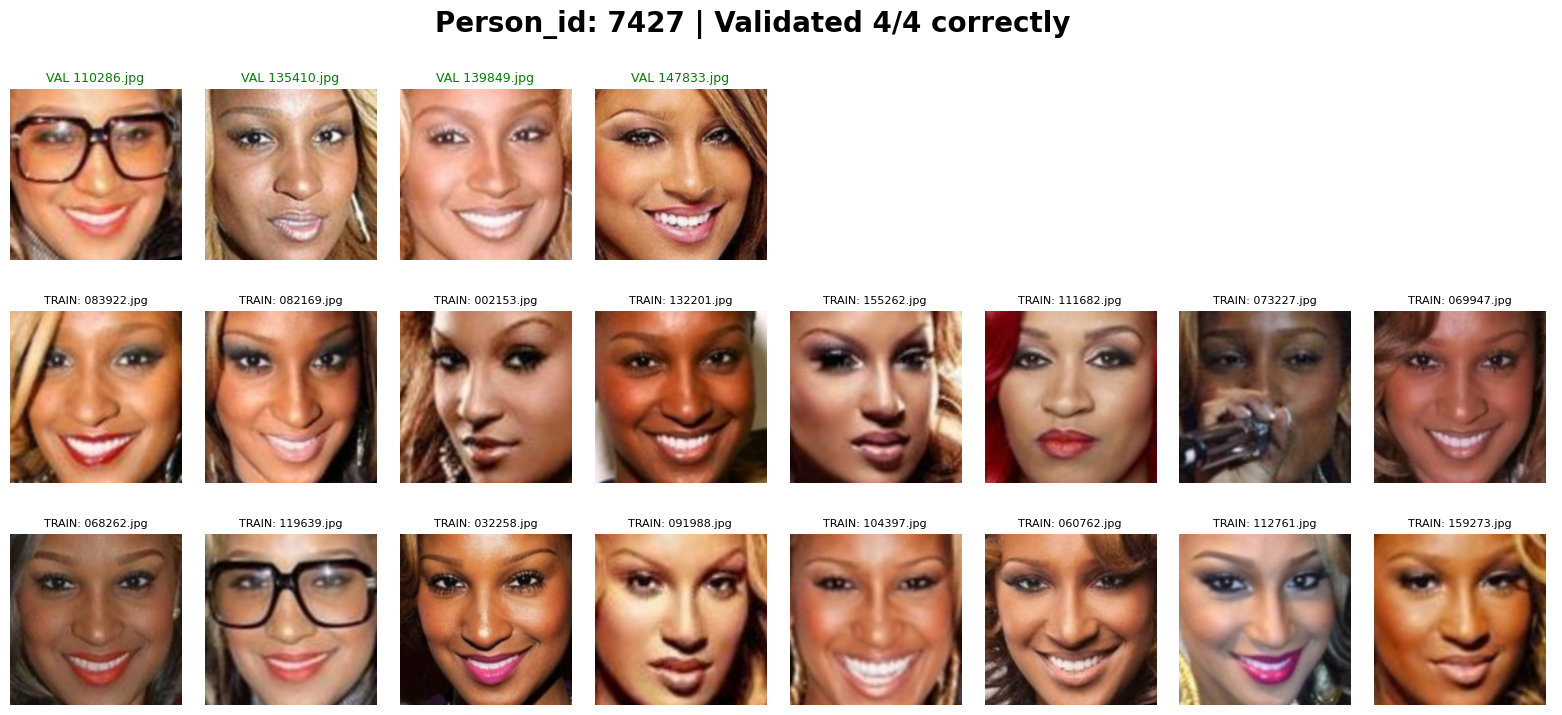

In [ ]:
visualize_person_full_history(val_report_df, 4)

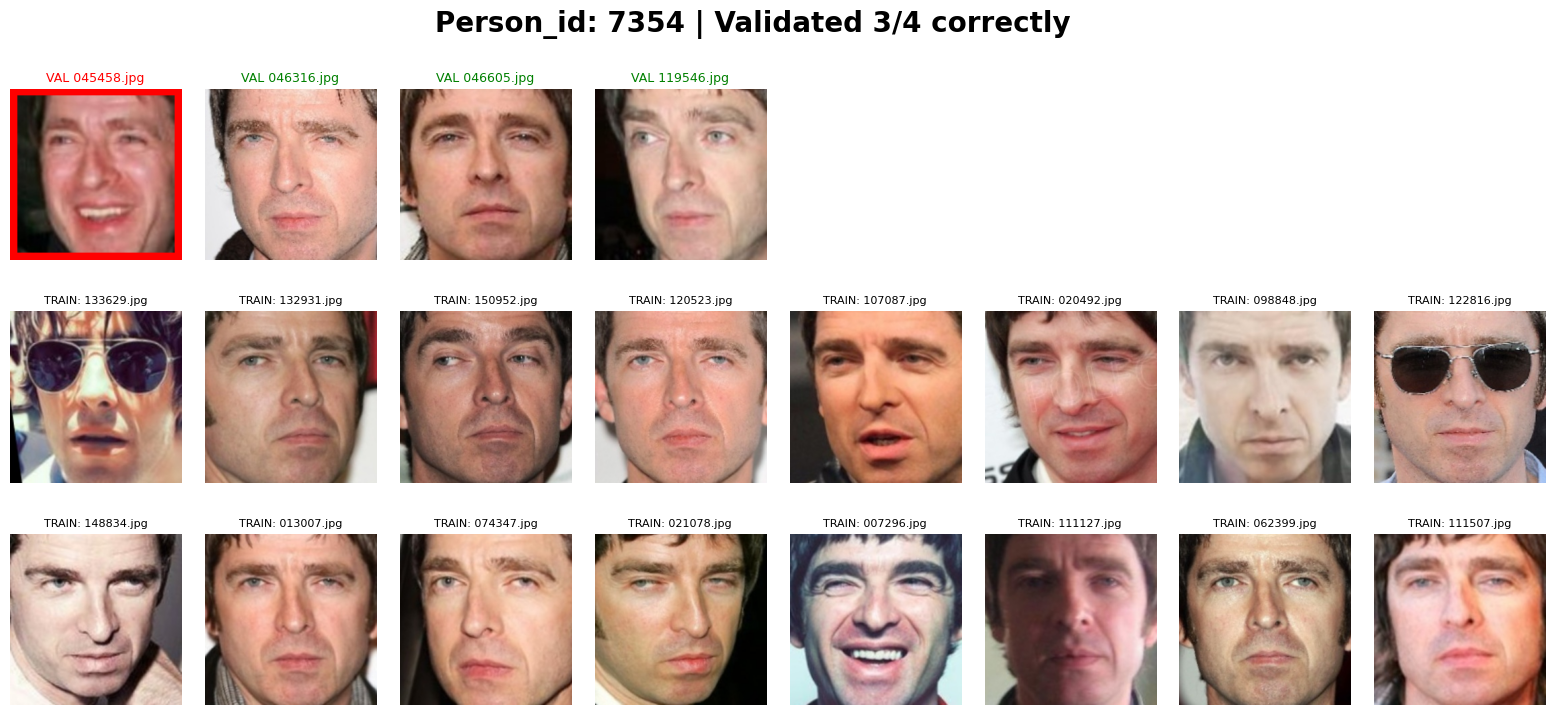

In [ ]:
visualize_person_full_history(val_report_df, 3)

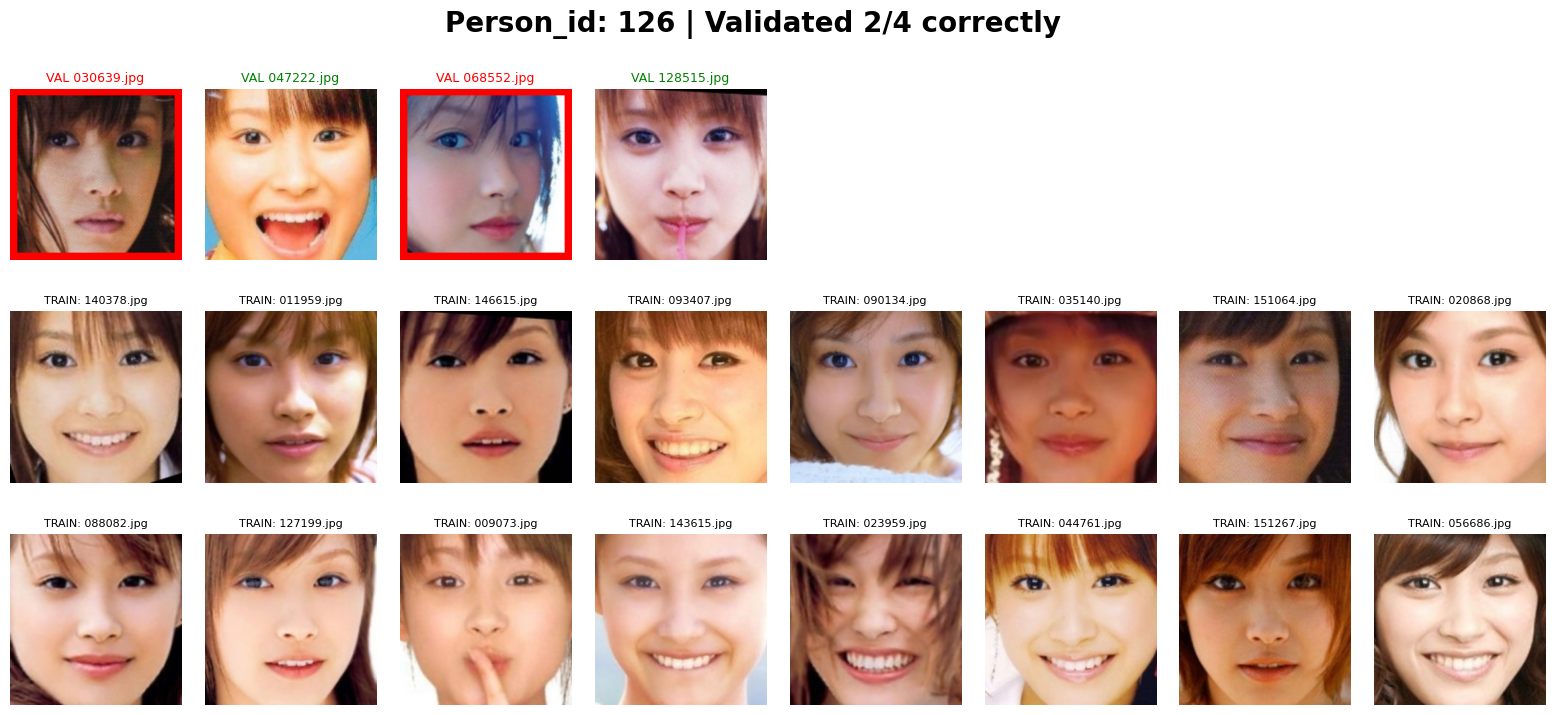

In [ ]:
visualize_person_full_history(val_report_df, 2)

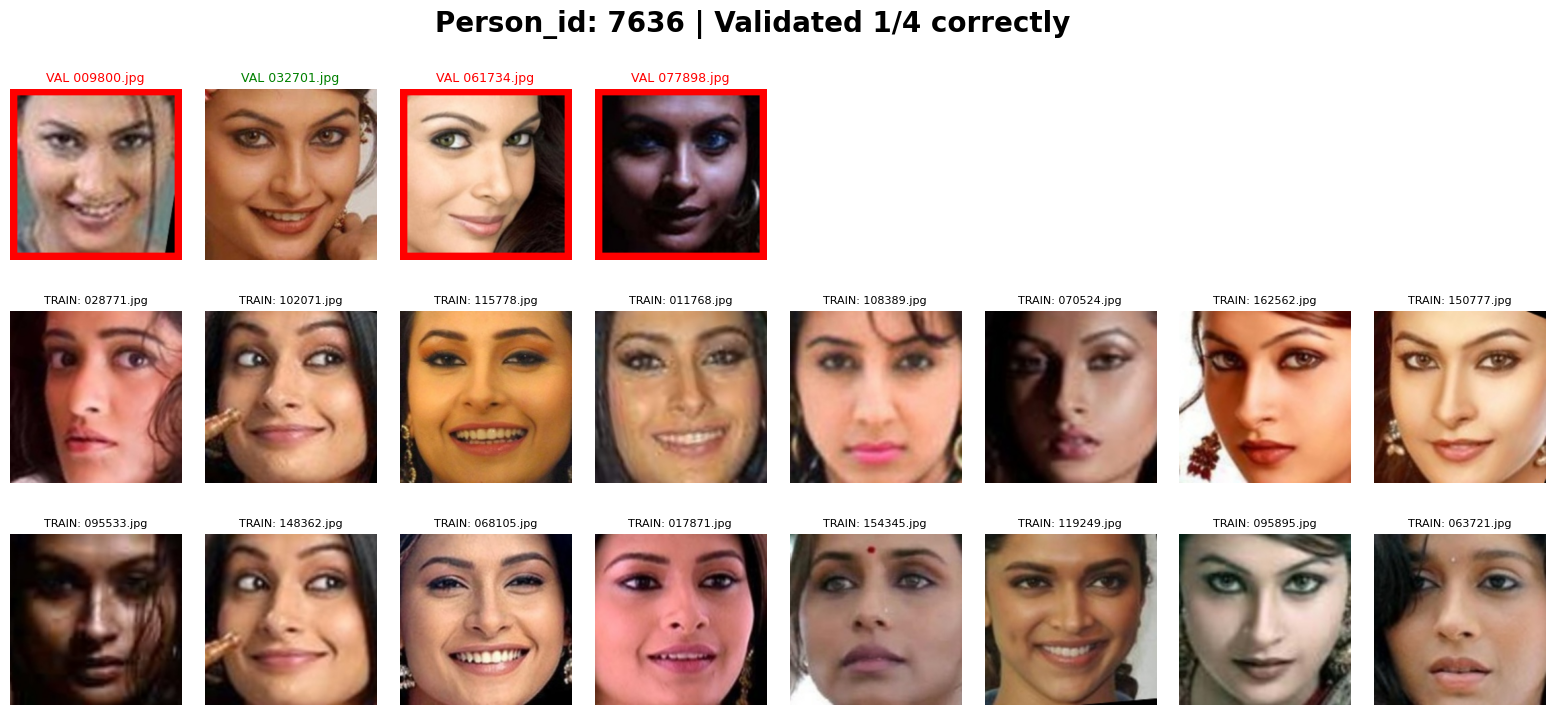

In [ ]:
visualize_person_full_history(val_report_df, 1)

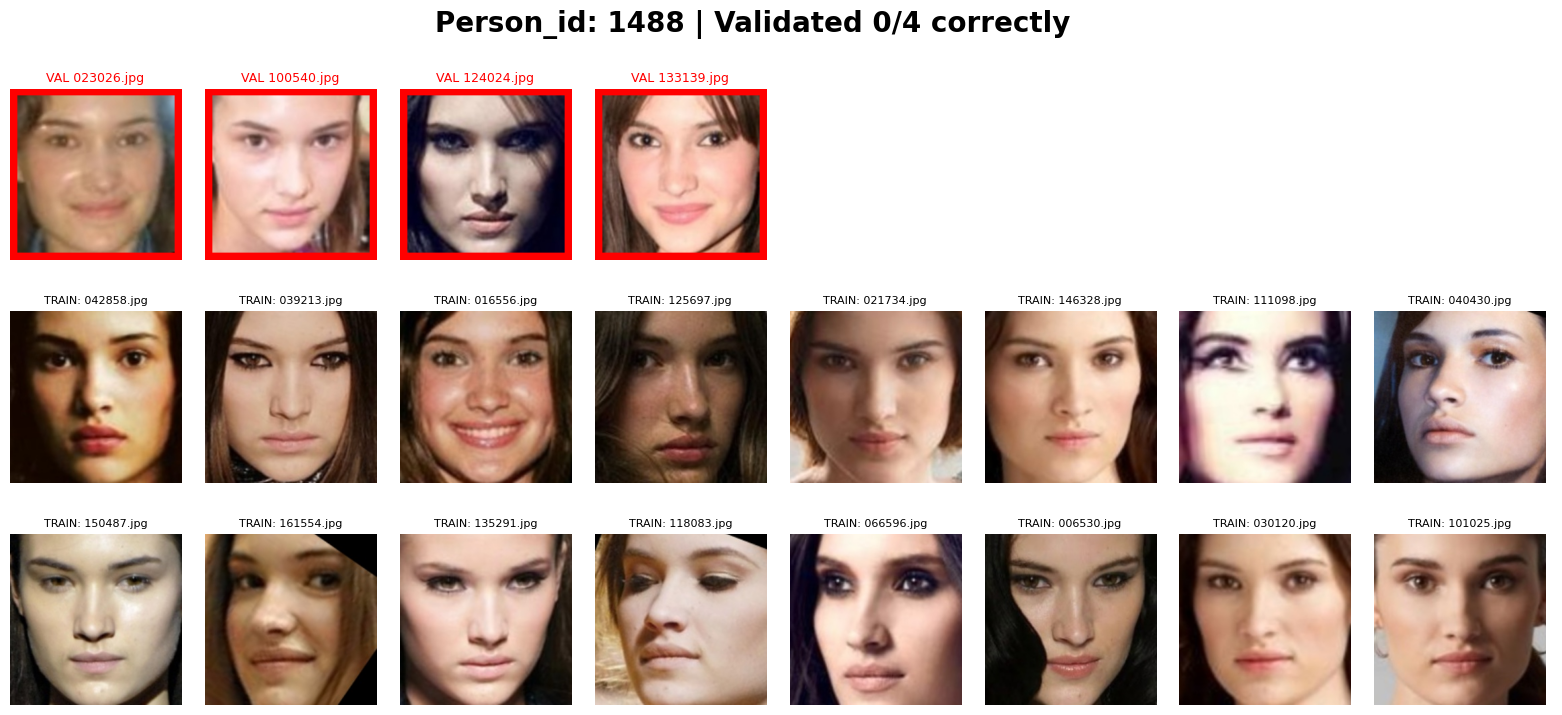

In [ ]:
visualize_person_full_history(val_report_df, 0)